# Objectifs
Implémenter la rétroprojection filtrée 2D en géométrie parallèle. L'algorithme consiste à rétroprojeter:
$$
f(\vec{x})=\int_0^\pi p^*_\theta(\vec{x}\cdot\vec{u_\theta})\mathrm{d}\theta
$$
les projections filtrées avec un filtre rampe:
$$
p^*_\theta(s) = \int_{-\infty}^\infty \lvert \rho \rvert \hat p_\theta(\rho)e^{2\pi i\rho s}\mathrm{d}\rho
$$
avec $\vec{u_\theta}=(\cos \theta,\sin\theta)$ l'orientation du détecteur et $\hat p_\theta$ la transformée de Fourier 1D de $p_\theta$.

Le dessin ci-dessous ilustre les notations utilisées dans ce notebook:

![parallel_fig.png](parallel_fig.png)

Dans un deuxième temps nous nous intéresserons à un algorithme de reconstruction itératif: Maximum-Likelihood Expectation-Maximization (MLEM). 

Enfin, il s’agira de comparer les temps de calcul et la qualité des différentes reconstructions de chacune des deux méthodes.

# Données
Nous allons travailler sur une coupe du fantôme de Shepp Logan 3D.
Le code utilisé pour produire l'image de `réference` est donné ci-dessous:

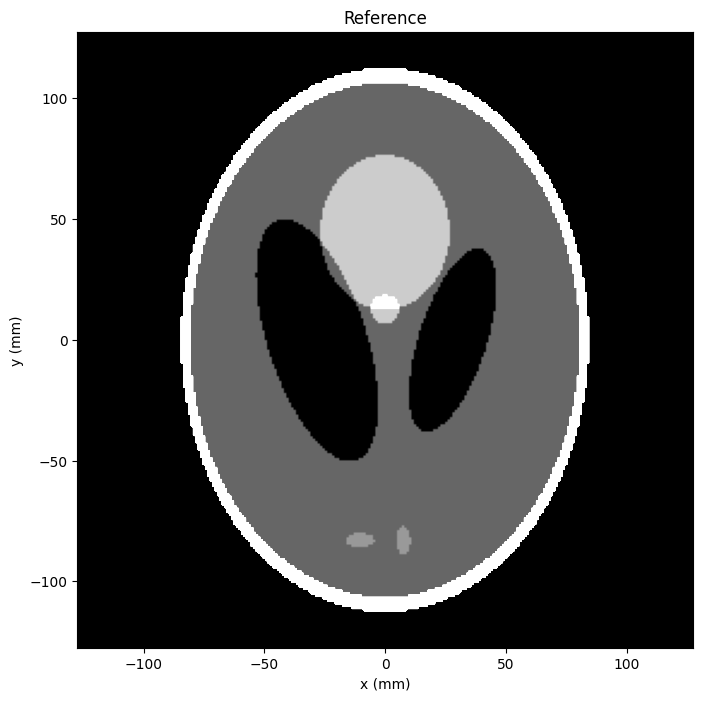

In [90]:
import numpy as np
import itk
from itk import RTK as rtk

# Define the image type, we will use 3D float images in these hands-on sessions
ImageType = itk.Image[itk.F,3]

# Create an image filled with 0 in which we will draw the phantom
srcdraw = rtk.ConstantImageSource[ImageType].New()
srcdraw.SetConstant(0.) # Note that this is useless because 0 is the default
srcdraw.SetSize([256,1,256])
srcdraw.SetSpacing([1,1,1])
srcdraw.SetOrigin([-127.5,0.,-127.5])

# Draw the Shepp Logan in it
sldraw = rtk.DrawSheppLoganFilter[ImageType, ImageType].New()
sldraw.SetInput(srcdraw.GetOutput())
sldraw.SetPhantomScale(128)
sldraw.SetOriginOffset([0.,0.25,0.])
sldraw.InPlaceOff()
sldraw.Update()
itk.imwrite(sldraw.GetOutput(),'ref.mha')
reference = itk.GetArrayFromImage(sldraw.GetOutput()).squeeze()

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
x=np.linspace(srcdraw.GetOrigin()[0],
               srcdraw.GetOrigin()[0]+(srcdraw.GetSize()[0]-1)*srcdraw.GetSpacing()[0],
               num=reference.shape[1])
y=np.linspace(srcdraw.GetOrigin()[2],
               srcdraw.GetOrigin()[2]+(srcdraw.GetSize()[2]-1)*srcdraw.GetSpacing()[2],
               num=reference.shape[0])
plt.imshow(reference, clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Reference')
plt.show();

et la fonction permettant de calculer les projections est la suivante:

In [91]:
def RadonTransformSheppLogan(thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)

    # Create an image filled with 0 in which we will draw the phantom
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],1,len(thetadeg)])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],0.,0.])

    # Project the Shepp Logan in it
    slproj = rtk.SheppLoganPhantomFilter[ImageType, ImageType].New()
    slproj.SetInput(srcproj.GetOutput())
    slproj.SetGeometry(geometry)
    slproj.SetPhantomScale(128)
    slproj.SetOriginOffset([0.,0.25,0.])
    slproj.Update()
    sinogram = itk.GetArrayFromImage(slproj.GetOutput()).squeeze()
    s=np.linspace(srcproj.GetOrigin()[0],
              srcproj.GetOrigin()[0]+(srcproj.GetSize()[0]-1)*srcproj.GetSpacing()[0],
              num=srcproj.GetSize()[0])
    return sinogram, s

**Exercice:** Tracer le sinogramme en précisant $N_\theta$, le nombre d'angles choisi dans l'intervalle $[0°,180°[$

Text(0.5, 1.0, 'Sinogram')

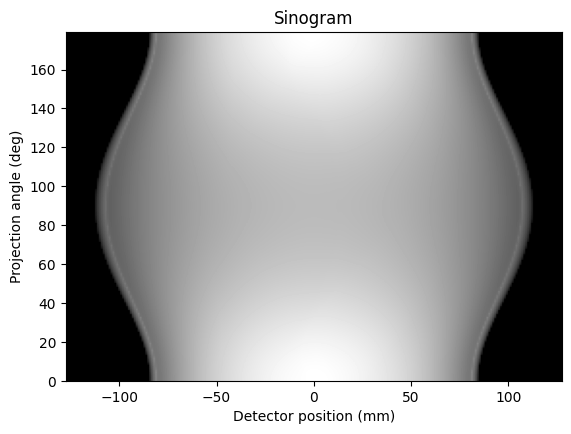

In [92]:
Ntheta = 256
thetadeg = np.linspace(0,180,Ntheta,endpoint=False)
sinogram, s = RadonTransformSheppLogan(thetadeg)
plt.imshow(sinogram, 'gray',extent=(s[0],s[-1],thetadeg[0],thetadeg[-1]),origin='lower')
plt.ylabel('Projection angle (deg)')
plt.xlabel('Detector position (mm)')
plt.title('Sinogram')

# Rétroprojection
On cherche maintenant à inverser la projection, i.e. à passer du domaine de Radon au domaine image.

**Exercice:** Implémenter dans un premier temps la rétroprojection simple de la transformée de Radon:
$$
f(\vec{x})=\int_0^\pi p_\theta(\vec{x}\cdot\vec{u_\theta})\mathrm{d}\theta = \int_0^\pi p_\theta(x cos(\theta)+y sin(\theta))\mathrm{d}\theta
$$
qui après discrétisation donne:
$$
f(x, y)=\Delta \theta \sum_{k=0}^{N_\theta-1} p_{\theta_k}(x cos(\theta_k) + y sin(\theta_k))
$$

Pour l'algorithme de la rétroprojection filtrée, la meilleure solution pour implémenter l'opérateur de rétroprojection est d'utiliser un *pixel-based* rétroprojecteur:
- Calculer les coordonnées 2D de chaque pixel de la fonction discretisée $f$. 
- Regarder où se projette chaque pixel sur chaque projection 1D $p_\theta$.
- Faire une interpolation linéraire des projections à ces posisitions.
- Ajouter la valeur interpolée au pixel.

![pixel-based](pixel_based_backprojection.png)

Vous pouvez utiliser la fonction [numpy.meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) pour obtenir une grille de coordonnées à partir des coordonnées des vecteurs $x$ et $y$ (voir leur définition dans la section Donnée). Utilisez l'option`indexing='xy'` pour être cohérent avec la `réference`. Vous pouvez utiliser [numpy.interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) pour l'interpolation linéaire.

(256, 256)
(256, 256)
0.01231997119054821
(256, 256)
(256,)


Text(0.5, 1.0, 'rétroprojection')

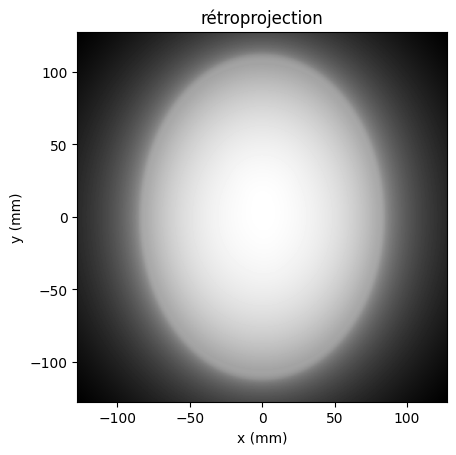

In [93]:
[X,Y] = np.meshgrid(x,y, indexing='xy')
print(np.shape(X))
print(np.shape(Y))
delta = np.deg2rad(180/(Ntheta-1))
print(delta)
f = np.zeros(np.shape(reference))
print(np.shape(f))
theta_rad = np.deg2rad(thetadeg)
print(np.shape(theta_rad))

for i in range(Ntheta):
    rho = (X*np.cos(theta_rad[i]) + Y*np.sin(theta_rad[i]))
    f += np.interp(rho, s, sinogram[i])
f *= delta
plt.imshow(f, 'gray',extent=(x[0],x[-1],y[0],y[-1]),origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('rétroprojection')

Le code suivant réalise la rétroprojection simple en utilisant RTK.

In [94]:
def BackprojectionRTK(thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    theta = np.deg2rad(thetadeg)
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)
        
    # Recreate projections with 3 slices to accomodate bilinear interpolation
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],3, len(thetadeg)])
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],-1.*srcdraw.GetSpacing()[1],0])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    slproj = rtk.SheppLoganPhantomFilter[ImageType, ImageType].New()
    slproj.SetInput(srcproj.GetOutput())
    slproj.SetGeometry(geometry)
    slproj.SetPhantomScale(128)
    slproj.SetOriginOffset([0.,0.25,0.])
    slproj.Update()

    # Backproject
    rtkbp = rtk.BackProjectionImageFilter[ImageType, ImageType].New()
    rtkbp.SetInput(0,srcdraw.GetOutput())
    rtkbp.SetInput(1,slproj.GetOutput())
    rtkbp.SetGeometry(geometry)
    rtkbp.Update()
    rtkbp = itk.GetArrayFromImage(rtkbp).squeeze()
    rtkbp *= np.abs(theta[1]-theta[0])
    
    return rtkbp

**Exercice:** Valider votre rétroprojection en la comparant à celle de RTK. La méthode de rétroprojection simple est-elle satisfaisante ? Expliquer pourquoi.

Text(0.5, 1.0, 'rétroprojection RTK')

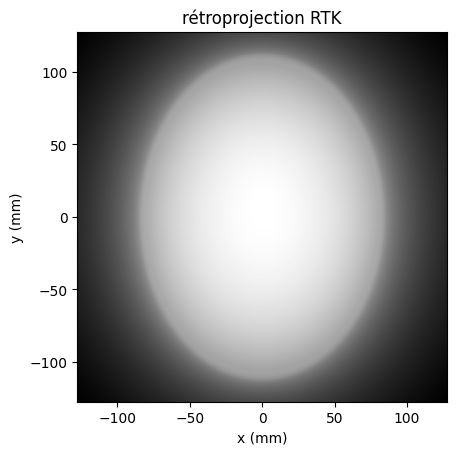

In [95]:
rtkbp = BackprojectionRTK(thetadeg)
plt.imshow(rtkbp, 'gray',extent=(x[0],x[-1],y[0],y[-1]),origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('rétroprojection RTK')

# Filtre Rampe
La version analytique du filtre rampe $\hat h(\rho)=|\rho|$ n'est pas utilisable dans notre cas du fait que les signaux numériques possèdent un spectre limité. Le filtre s'exprime donc par: 
$$
\hat h_\mathrm{BL}(\rho)=\left\{
\begin{array}{ll}%
\lvert \rho \rvert &\mathrm{si}\ \lvert \rho \rvert <\rho\\
0 & \mathrm{sinon,}\\
\end{array}
\right.
$$
où $\rho=1/2\Delta_s$ est la frèquence maximum respectant la condition de Nyquist-Shannon pour un signal échantillonée à $\Delta_s$. Il existe plusieurs implémentations du filtre rampe verifiant cette condition, une des plus communes est: 
$$
h_\mathrm{BL}(s)=\dfrac{1}{2\Delta_s^2}\dfrac{\sin 2\pi s/2\Delta_s}{2\pi s/2\Delta_s}-\dfrac{1}{4\Delta_s^2}\left(\dfrac{\sin\pi s/2\Delta_s}{\pi s/2\Delta_s}\right)^2
$$
qui après discrétisation donne:
$$
h_\mathrm{BL}(n\Delta_s)=
\begin{cases}
\dfrac{1}{4\Delta_s^2} &\mathrm{si}\ n=0,\\
0 &\mathrm{si}\ n\ \mathrm{est\ pair},\\
-\dfrac{1}{\left(n\pi \Delta_s\right)^2} &\mathrm{si}\ n\ \mathrm{est\ impair}.\\
\end{cases}
$$

Le code suivant retourne ce filtre à la fois dans le domaine spatial et fréquentiel:

In [96]:
def RampFilterBL(s, zeropad=2):
    rampbl = np.zeros(s.size*zeropad)
    ds=s[1]-s[0]
    rampbl[s.size*zeropad//2-1]=1/(4*ds**2)
    idxodd = np.concatenate((np.flip(-1*np.arange(1,rampbl.size//2,2)),np.arange(1,rampbl.size//2,2)))
    rampbl[0::2]=-1/(idxodd*np.pi*ds)**2
    rampbl*=ds
    rampbl_fft = np.absolute(np.fft.rfft(rampbl))
    
    return rampbl, rampbl_fft

**Exercice:** En utlisant la fonction précédente, implémentez la rétroprojection filtrée. Vous pouvez utiliser la fonction [numpy.fft.irfft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.irfft.html) pour la transformée de Fourier 1D inverse, et [numpy.fft.rfftfreq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfftfreq.html) pour récupérer l'échantillonage des fréquences dans le domaine de Fourier.
Comparer l'image reconstruite avec la référence (vous pourrez notamment afficher un profil). Expliquer l'intérêt et l'effet du filtre rampe lors de la rétroprojection.

(256, 256)
(256, 257)
(512,)
(257,)
(256, 257)
(256, 256)


Text(0.5, 1.0, 'rétroprojection')

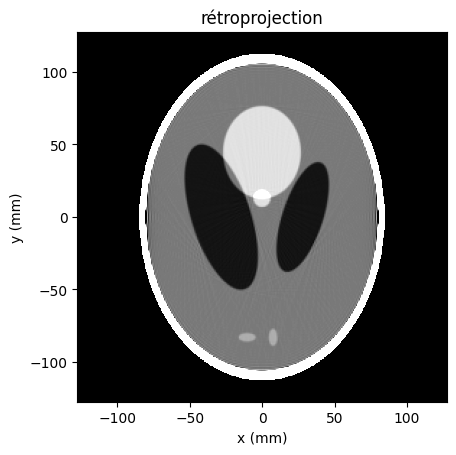

In [97]:
TF = np.fft.rfft(sinogram, axis=1, n = sinogram.shape[0]*2)
print(np.shape(sinogram))
print(np.shape(TF))
plt.imshow(np.abs(TF))

rampbl, rampbl_fft = RampFilterBL(s)
print(np.shape(rampbl))
print(np.shape(rampbl_fft))
TF_sinogram_filtre = TF*rampbl_fft
print(np.shape(TF_sinogram_filtre))
sinogram_filtre = np.fft.irfft(TF_sinogram_filtre, axis=1)[:,:sinogram.shape[1]]
print(np.shape(sinogram_filtre))

[X,Y] = np.meshgrid(x,y, indexing='xy')
delta = np.deg2rad(180/(Ntheta-1))
f_inv = np.zeros(np.shape(reference))
theta_rad = np.deg2rad(thetadeg)

for i in range(Ntheta):
    rho = (X*np.cos(theta_rad[i]) + Y*np.sin(theta_rad[i]))
    f_inv += delta*np.interp(rho, s, sinogram_filtre[i])

plt.imshow(f_inv,clim=[1,1.05],cmap= 'gray',extent=(x[0],x[-1],y[0],y[-1]),origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('rétroprojection')

**Exercice:** Comparer les qualités d'images reconstruites, les PSNR obtenus et le temps de reconstruction en fonction de $N_\theta$. Pour mesurer le temps de calcul vous pouvez utiliser la fonction [time.time()](https://docs.python.org/3/library/time.html).

Rappel: $\mathrm{PSNR}= 10 \log_{10}(\frac{\mathrm{MAX}^2_I}{\mathrm{MSE}})$

N'oubliez pas de normalier vos images avant de quantifier leur différence.

In [98]:
ref_norm = reference/np.max(reference)
f_inv_norm = f_inv/np.max(f_inv)
PSNR = 10*np.log10(np.max(ref_norm)**2/np.mean((ref_norm-f_inv_norm)**2))
print(PSNR)

26.91331908304126


**Exercice:** Rajouter un bruit additif Gaussien de moyenne nulle au sinogramme de départ en utilisant la fonction [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html). Pour un $N_\theta$ fixé, tracez l’évolution du PSNR en fonction de la variance du bruit.

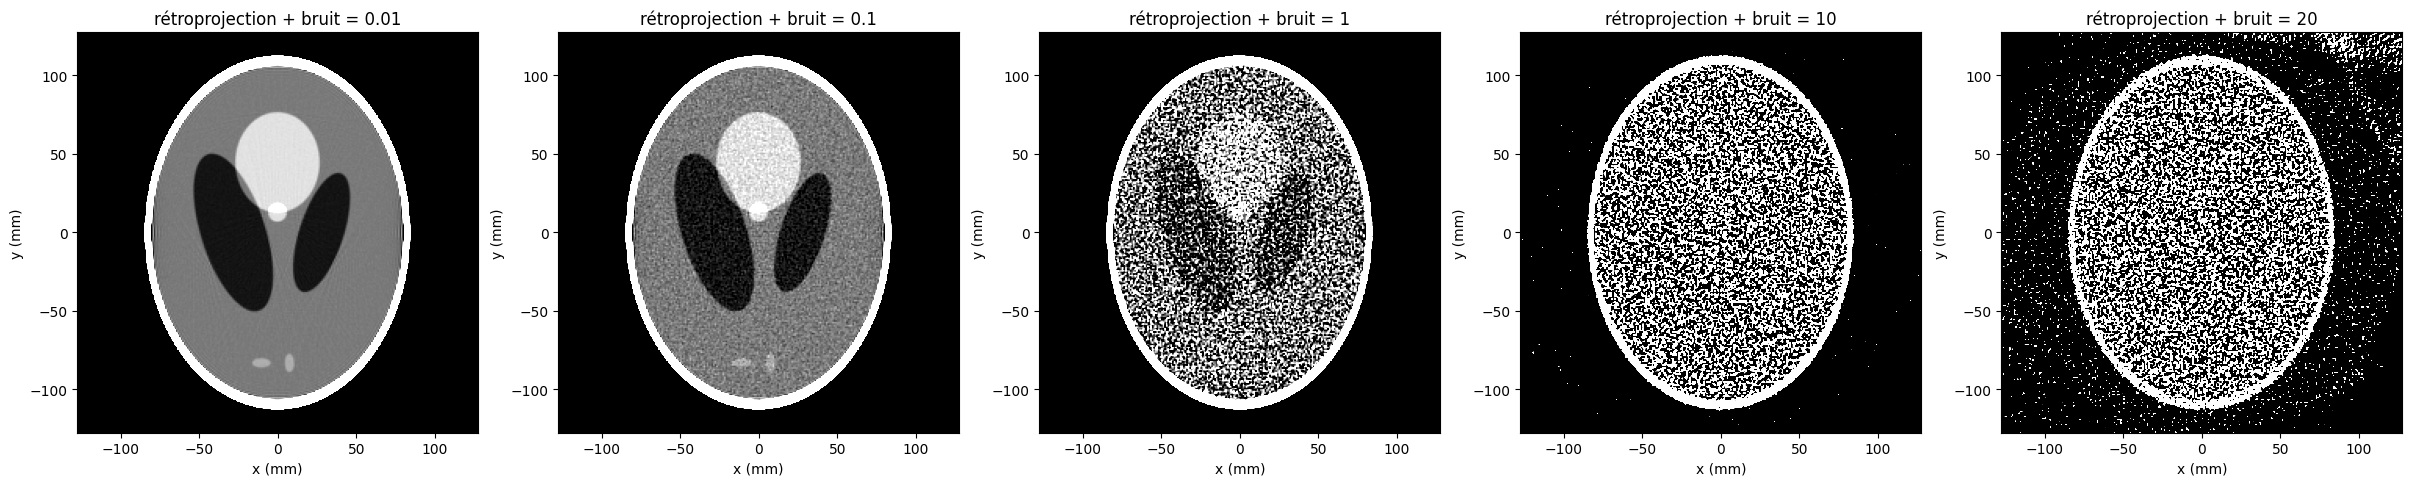

In [99]:
# plt.imshow(np.abs(TF))
bruit = [0.01, 0.1, 1, 10, 20]
fig = plt.figure(figsize=(30, 30))
def filtre(b,length,idx):
    fig.add_subplot(1,length,idx+1)
    sinogram_bruite = sinogram + np.random.normal(0,b,sinogram.shape)
    TF = np.fft.rfft(sinogram_bruite, axis=1, n = sinogram_bruite.shape[0]*2)
    rampbl, rampbl_fft = RampFilterBL(s)
    TF_sinogram_filtre = TF*rampbl_fft
    sinogram_filtre = np.fft.irfft(TF_sinogram_filtre, axis=1)[:,:sinogram.shape[1]]

    [X,Y] = np.meshgrid(x,y, indexing='xy')
    delta = np.deg2rad(180/(Ntheta-1))
    f_inv = np.zeros(np.shape(reference))
    theta_rad = np.deg2rad(thetadeg)

    for i in range(Ntheta):
        rho = (X*np.cos(theta_rad[i]) + Y*np.sin(theta_rad[i]))
        f_inv += delta*np.interp(rho, s, sinogram_filtre[i])

    plt.imshow(f_inv,clim=[1,1.05],cmap= 'gray',extent=(x[0],x[-1],y[0],y[-1]),origin='lower')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title('rétroprojection + bruit = '+str(b))
for b in range(len(bruit)):
    filtre(bruit[b],len(bruit),b)

## My retroprojecteur

In [102]:
def retroprojecteur(thetadeg, sinogram):
    
    [X,Y] = np.meshgrid(x,y, indexing='xy')
    delta = np.deg2rad(180/(Ntheta-1))
    f = np.zeros(np.shape(reference))
    thetarad = np.deg2rad(thetadeg)
    for i in range(Ntheta):
        rho = (X*np.cos(thetarad[i]) + Y*np.sin(thetarad[i]))
        f += np.interp(rho, s, sinogram[i])

    f *= delta
    return f 

# Bonus (si vous avez le temps)
Nous avons vu dans le cours que le filtre rampe favorise l'amplification des hautes fréquences et peut introduire du bruit dans l'image reconstruite. Une solution est d'appliquer un filtre passe-bas appelé fenêtre d'apodisation pour atténuer les hautes-fréquences. Le filtre de Hann est couramment utilisé à cet effet:
$$
\hat w(\sigma)=\left\{
\begin{array}{ll}%
0.5*(1+\cos(\frac{\pi \rho}{\rho})) &\mathrm{si}\ \rho <\rho\\
0 & \mathrm{sinon}\\
\end{array}
\right.
$$

**Exercice:** Ajouter le filtre de Hann à votre rétroprojection filtrée et comparer les résultats obtenue pour différentes fréquences de coupure.

# MLEM
Nous supposons que l'émission des photons suit une distribution de Poisson, alors, si $\vec{f}$ représente le vecteur image $\vec{f} = (f_i,..,f_n)^t$ et $\vec{p} = (p_1,..,p_m)^t$ les projections mesurées, la fonction de vraisemblance, qui est la probabilité d'obtenir $\vec{p}$ si l'image est $\vec{f}$, est:
$$
			P_L(\vec{p}/\vec{f}) = \prod_{i=1}^m \frac{\sum_{j=1}^n (r_{ij}f_j)^{p_i}}{p_i!} \exp(-\sum_{j=1}^n r_{ij}f_j)
$$
où $r_{ij}$ représente la probabilité qu'un photon émis par le voxel j soit détecté par le pixel i et $\sum_{i=1}^m r_{ij} = 1$. 

Afin d'estimer $\vec{f}$ à partir de $\vec{p}$, une approche possible est de maximiser $P_L(\vec{p}/\vec{f})$ ou de façon équivalente:
$$
			\max_{\vec{f}\ge0}L(\vec{f})=\sum_{i=1}^m (p_i \ln(\sum_{j=1}^n r_{ij}f_j) - \sum_{j=1}^n r_{ij}f_j)
$$

L'algorithme MLEM cherche une solution qui maximise cette fonction de vraisemblance entre les projections mesurées et les projections de l'image. L'équation de mise à jour est:
$$
			f^{next}_{j} = \frac{f^{current}_{j}}{{\sum_{i} r_{ij}}} {\sum_{i} r_{ij}} \frac{{p_{i}}}{{{\sum_{j} r_{ij}}}f^{current}_{j}}
$$
où $\sum_{i} r_{ij}$ représente l'opérateur de rétroprojection et $\sum_{j} r_{ij}$ l'opérateur de projection.

Une implémentation d'un opérateur de projection est donnée par la fonction suivante:

In [100]:
def ForwardProjectionRTK(volume, thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)
    
    # Create an image filled with 0 in which we write the projections
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],1,len(thetadeg)])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],0,0.])
    srcproj.Update()
    
    volume = volume[:, np.newaxis, :]
    volume = np.append(volume, np.zeros((volume.shape[0],2,volume.shape[2])), axis=1)
    itkVolume = itk.GetImageFromArray(volume.astype(np.float32))
    itkVolume.SetSpacing([1,1,1])
    itkVolume.SetOrigin([-127.5,0.,-127.5])

    jfp = rtk.JosephForwardProjectionImageFilter[ImageType, ImageType].New()
    jfp.SetInput(0, srcproj.GetOutput())
    jfp.SetInput(1, itkVolume)
    jfp.SetGeometry(geometry)
    jfp.Update()
    jfp = itk.GetArrayFromImage(jfp.GetOutput()).squeeze()
    
    return jfp  

**Exercice:** En utilisant le projecteur implémenté ci-dessus et votre rétroprojecteur, créer une fonction réalisant la reconstruction par la méthode MLEM.

Dans un premier temps, le nombre d'itération sera fixé.

Text(0.5, 1.0, 'rétroprojection MLEM')

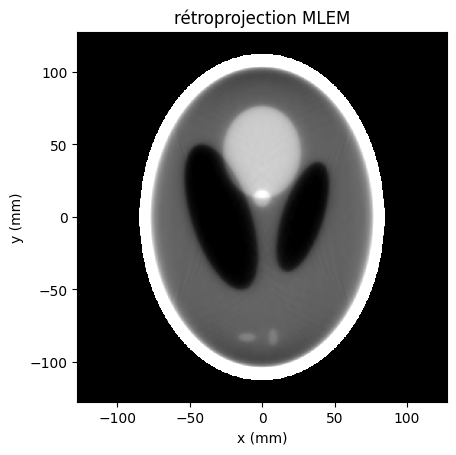

In [118]:
Niter = 30
LogVraisemblence = []
MSE = []
SAVE_IMG = False
fn = np.ones(reference.shape)
zero = np.zeros(sinogram.shape)
f = retroprojecteur(thetadeg, np.ones(sinogram.shape))


for i in range(Niter):
    jfp = ForwardProjectionRTK(fn, thetadeg)
    p_error = np.divide(sinogram, jfp, where=jfp!=0, out=zero)

    f_corr = retroprojecteur(thetadeg, p_error)
    fn = fn*f_corr/f

    # quadratic_error = np.mean((fn-reference)**2)
    # MSE.append(quadratic_error)
    # cost=0
    # LogVraisemblence.append(cost)

plt.imshow(fn,clim=[1,1.05],cmap= 'gray',extent=(x[0],x[-1],y[0],y[-1]),origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('rétroprojection MLEM')  
    

**Exercice:** Vérifier que l'algorithme MLEM maximise bien la fonction de coût en traçant son évolution en fonction du nombre d'itérations. Tracer aussi l'évolution de l'erreur quadratique moyenne pour vérifier que le volume reconstruit se rapproche bien de la référence.

En déduire un critère de convergence de l'algorithme plus pertinent qu'un nombre fixé d'itérations.

# Bilan
**Exercice:** En fixant les mêmes paramètres (bruit, taille de l’image, nombre de projections) comparer les reconstructions obtenues (PSNR, temps de calcul, perception visuelle) par les deux méthodes implémentées.

### OSEM MÉTHODE